In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
samples = pd.read_csv('../data/TCGA/rna-seq_adeno/meta/gdc_sample_sheet.2020-01-27.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Project ID'].value_counts()

TCGA-LUSC    301
TCGA-LUAD    287
CPTAC-3      209
Name: Project ID, dtype: int64

Samples with RNAseq adjacent normal tissue

In [4]:
samples['Sample Type'].value_counts()

Primary Tumor                               558
Solid Tissue Normal                         206
Primary Tumor, Primary Tumor                 29
Solid Tissue Normal, Solid Tissue Normal      4
Name: Sample Type, dtype: int64

In [5]:
samples.loc[samples['Sample Type']=='Primary Tumor, Primary Tumor', 'Sample Type'] = 'Primary Tumor'
samples.loc[samples['Sample Type']=='Solid Tissue Normal, Solid Tissue Normal', 'Sample Type'] = 'Solid Tissue Normal'

In [6]:
samples['Sample Type'].value_counts()

Primary Tumor          587
Solid Tissue Normal    210
Name: Sample Type, dtype: int64

In [7]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [8]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

176

210

In [9]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(187,)

In [10]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [11]:
case_tumor.shape
case_norm.shape
cases.shape

(187, 9)

(176, 9)

(363, 9)

## Map Ensembl genes to Proteins

In [12]:
# id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv")
# reviewed_proteins = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/TCGA_rnaseq_uniprot_features.tab.gz", sep="\t")
# proteins = pd.merge(id_map, reviewed_proteins, left_on='UNIPROT_ID', right_on='Entry name')
# proteins.shape

## Dataset Prep

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          140
Solid Tissue Normal    132
Name: Sample Type, dtype: int64

Primary Tumor          47
Solid Tissue Normal    44
Name: Sample Type, dtype: int64

In [14]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [15]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_adeno/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

#### Subset gene data to annotated proteins

In [16]:
# train_dataset.data.columns = [ens[0] for ens in train_dataset.data.columns.str.split(".")]
# test_dataset.data.columns = [ens[0] for ens in test_dataset.data.columns.str.split(".")]

# train_dataset.data = train_dataset.data[train_dataset.data.columns[np.isin(train_dataset.data.columns, proteins['ENSEMBL_ID'].values)]]
# test_dataset.data = test_dataset.data[test_dataset.data.columns[np.isin(test_dataset.data.columns, proteins['ENSEMBL_ID'].values)]]

## Siamese Network

In [17]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [18]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/272 (0%)]	Loss: 0.186468
Train: [240/272 (88%)]	Loss: 0.573355
Epoch: 1/20. Train set: Average loss: 0.5241
Epoch: 1/20. Validation set: Average loss: 1.0224
Train: [0/272 (0%)]	Loss: 0.225592
Train: [240/272 (88%)]	Loss: 0.144387
Epoch: 2/20. Train set: Average loss: 0.1403
Epoch: 2/20. Validation set: Average loss: 0.1574
Train: [0/272 (0%)]	Loss: 0.048625
Train: [240/272 (88%)]	Loss: 0.056677
Epoch: 3/20. Train set: Average loss: 0.0552
Epoch: 3/20. Validation set: Average loss: 0.0598
Train: [0/272 (0%)]	Loss: 0.051783
Train: [240/272 (88%)]	Loss: 0.021570
Epoch: 4/20. Train set: Average loss: 0.0218
Epoch: 4/20. Validation set: Average loss: 0.0240
Train: [0/272 (0%)]	Loss: 0.008680
Train: [240/272 (88%)]	Loss: 0.010830
Epoch: 5/20. Train set: Average loss: 0.0102
Epoch: 5/20. Validation set: Average loss: 0.0387
Train: [0/272 (0%)]	Loss: 0.010867
Train: [240/272 (88%)]	Loss: 0.022442
Epoch: 6/20. Train set: Average loss: 0.0212
Epoch: 6/20. Validation set: Average loss:

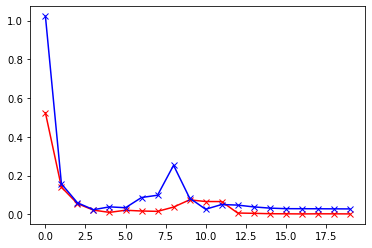

In [19]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

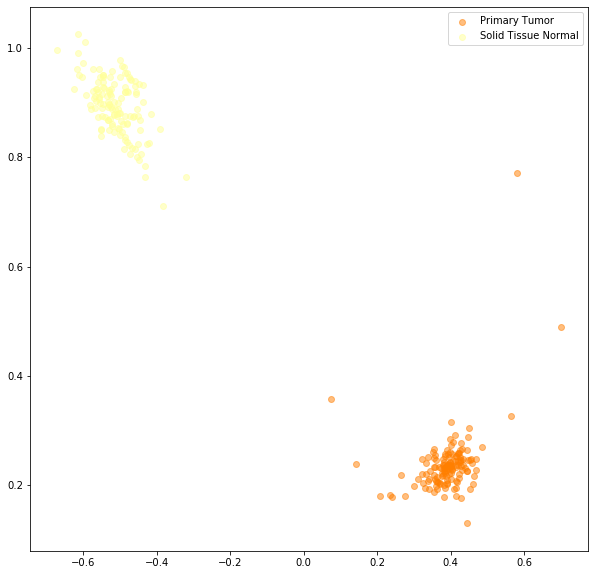

In [20]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

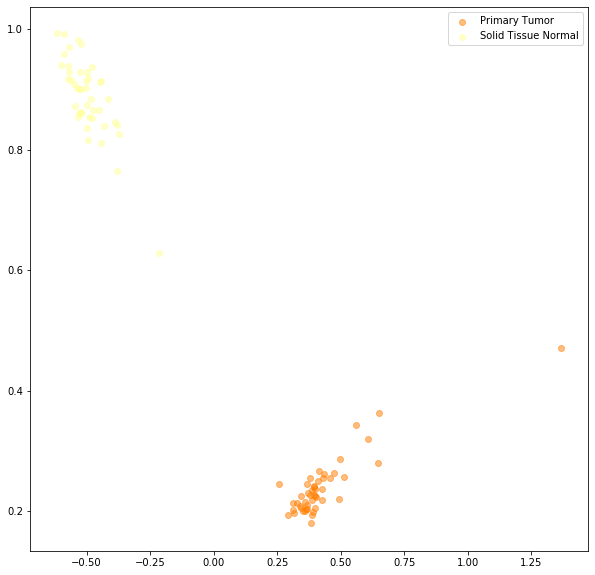

In [21]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [22]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [23]:
id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv")
reviewed_proteins = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/TCGA_rnaseq_uniprot_features.tab.gz", sep="\t")
proteins = pd.merge(id_map, reviewed_proteins, left_on='UNIPROT_ID', right_on='Entry name')
proteins.shape

(18842, 21)

In [24]:
proteins.head()

,ENSEMBL_ID,UNIPROT_ID,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Cross-reference (GeneID),Cross-reference (KEGG),Cross-reference (ExpressionAtlas),Tissue specificity,Gene names (primary ),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Ensembl transcript
0,ENSG00000000005,TNMD_HUMAN,Q9H2S6,TNMD_HUMAN,reviewed,Tenomodulin (TeM) (hTeM) (Chondromodulin-1-lik...,TNMD CHM1L UNQ771/PRO1565,Homo sapiens (Human),317,Alternative sequence (3); Chain (1); Disulfide...,64102;,hsa:64102;,NaN,TISSUE SPECIFICITY: Highly expressed in hypova...,TNMD,cellular response to BMP stimulus [GO:0071773]...,cytoplasm [GO:0005737]; integral component of ...,cytoplasm [GO:0005737]; integral component of ...,NaN,GO:0001886; GO:0001937; GO:0005635; GO:0005737...,ENST00000373031 [Q9H2S6-1];
1,ENSG00000000419,DPM1_HUMAN,O60762,DPM1_HUMAN,reviewed,Dolichol-phosphate mannosyltransferase subunit...,DPM1,Homo sapiens (Human),260,Chain (1); Initiator methionine (1); Modified ...,8813;,hsa:8813;,O60762;,NaN,DPM1,dolichol metabolic process [GO:0019348]; GPI a...,dolichol-phosphate-mannose synthase complex [G...,dolichol-phosphate-mannose synthase complex [G...,dolichyl-phosphate beta-D-mannosyltransferase ...,GO:0004169; GO:0004582; GO:0005634; GO:0005783...,ENST00000371588;
2,ENSG00000000457,PACE1_HUMAN,Q8IZE3,PACE1_HUMAN,reviewed,Protein-associating with the carboxyl-terminal...,SCYL3 PACE1,Homo sapiens (Human),742,Alternative sequence (1); Chain (1); Domain (1...,57147;,hsa:57147;,Q8IZE3;,TISSUE SPECIFICITY: Ubiquitously expressed. {E...,SCYL3,cell migration [GO:0016477]; cellular protein ...,cytoplasm [GO:0005737]; Golgi apparatus [GO:00...,cytoplasm [GO:0005737]; Golgi apparatus [GO:00...,ATP binding [GO:0005524]; identical protein bi...,GO:0000139; GO:0005524; GO:0005737; GO:0005794...,ENST00000367770 [Q8IZE3-1];ENST00000367771 [Q8...
3,ENSG00000000460,CA112_HUMAN,Q9NSG2,CA112_HUMAN,reviewed,Uncharacterized protein C1orf112,C1orf112,Homo sapiens (Human),853,Alternative sequence (2); Chain (1); Modified ...,55732;,hsa:55732;,Q9NSG2;,NaN,C1orf112,NaN,NaN,NaN,NaN,NaN,ENST00000286031 [Q9NSG2-1];ENST00000359326 [Q9...
4,ENSG00000000938,FGR_HUMAN,P09769,FGR_HUMAN,reviewed,Tyrosine-protein kinase Fgr (EC 2.7.10.2) (Gar...,FGR SRC2,Homo sapiens (Human),529,Active site (1); Binding site (1); Chain (1); ...,2268;,hsa:2268;,P09769;,"TISSUE SPECIFICITY: Detected in neutrophils, m...",FGR,bone mineralization [GO:0030282]; cell differe...,actin cytoskeleton [GO:0015629]; aggresome [GO...,actin cytoskeleton [GO:0015629]; aggresome [GO...,ATP binding [GO:0005524]; Fc-gamma receptor I ...,GO:0001784; GO:0002768; GO:0004713; GO:0004715...,ENST00000374003;ENST00000374004;ENST0000037400...


In [25]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

# IG with Control vector

In [26]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [27]:
from torch.nn import PairwiseDistance
pdist = PairwiseDistance(p=2)
pdist

PairwiseDistance()

In [28]:
ig = IntegratedGradients(model.get_dist)

In [29]:
torch.cuda.empty_cache()

## Zero vector as baseline

In [30]:
baseline = torch.zeros_like(ctrl_data)
baseline

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [31]:
attr, delta = ig.attribute(exp_data.cuda(), baseline.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([ 9.6370e-03,  9.5308e-05,  5.8115e-06,  1.7473e-03, -5.4343e-04,
         2.6346e-03, -5.5696e-03,  2.6670e-03,  7.4735e-03,  1.3341e-04,
         3.2901e-03,  2.7144e-03,  2.5988e-05,  3.3014e-03,  2.2278e-04,
         3.4660e-03,  2.6549e-03,  3.2626e-03,  3.1453e-03,  5.1747e-03,
         4.7104e-03,  1.6119e-03,  7.3612e-06,  8.4207e-05, -2.9403e-03,
         2.2492e-03, -1.5467e-05,  1.0535e-02,  3.9277e-03,  2.1851e-04,
         8.9990e-03,  3.6419e-03,  2.3217e-03,  2.0969e-03,  9.7751e-04,
         6.7718e-03,  1.5884e-03,  4.2755e-03, -3.1002e-05,  5.2014e-03,
         2.1667e-04,  9.4241e-03, -2.5898e-05,  2.3439e-03,  1.7772e-03],
       device='cuda:0')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f362101f3c8>]],
      dtype=object)

,Attribution
count,6.048300e+04
mean,1.807919e-06
std,8.141687e-06
min,-1.820657e-04
25%,-4.408284e-07
50%,7.572042e-07
75%,2.603705e-06
max,6.999475e-04


,Attribution
ENSG00000275664.1,0.000700
ENSG00000241088.2,0.000511
ENSG00000255454.1,0.000436
ENSG00000230066.4,0.000308
ENSG00000235139.2,0.000285
ENSG00000267487.1,0.000267
ENSG00000253692.3,0.000252
ENSG00000240298.3,0.000239
ENSG00000261122.5,0.000236
ENSG00000254490.1,0.000226


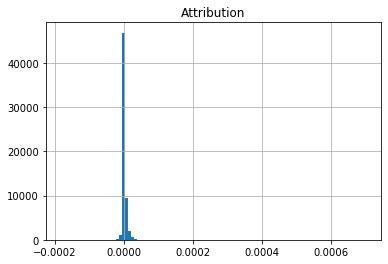

In [32]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

## Random Vector as baseline

In [33]:
baseline = torch.rand_like(exp_data)
baseline

tensor([[0.6682, 0.7212, 0.3665,  ..., 0.7331, 0.1939, 0.3992],
        [0.5650, 0.7385, 0.7091,  ..., 0.6047, 0.0199, 0.3798],
        [0.0252, 0.8777, 0.7246,  ..., 0.6438, 0.6531, 0.6208],
        ...,
        [0.7849, 0.3512, 0.0996,  ..., 0.3019, 0.7240, 0.8712],
        [0.2256, 0.2134, 0.0584,  ..., 0.4773, 0.1247, 0.2639],
        [0.3794, 0.7646, 0.7860,  ..., 0.6893, 0.1039, 0.5175]])

In [34]:
attr, delta = ig.attribute(exp_data.cuda(), baseline.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([-1.3611e-04, -2.4784e-04, -4.5565e-04,  6.9998e-05, -1.6254e-04,
        -1.1026e-04, -8.4773e-05, -4.6016e-04,  5.9351e-05,  1.8985e-04,
        -2.9062e-04, -2.1461e-04,  1.6883e-05, -1.0817e-04,  7.0877e-05,
        -4.7505e-05,  3.0164e-04,  3.1611e-04, -4.3119e-04, -1.0489e-04,
        -7.5042e-05, -1.7011e-04,  2.5943e-04,  5.1580e-05, -1.9467e-04,
        -2.0551e-04, -6.9819e-05, -4.8488e-05,  1.3550e-04, -5.8759e-05,
        -1.9579e-04,  2.7722e-04,  5.4404e-05,  3.4526e-05, -2.8247e-04,
        -2.1267e-04,  8.9407e-07, -6.7960e-05, -1.0224e-04, -9.4831e-04,
        -2.0002e-04, -1.9222e-04, -9.3192e-05,  3.0480e-04,  9.6634e-05],
       device='cuda:0')

In [35]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
#feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

,Attribution
count,6.048300e+04
mean,1.210520e-06
std,1.201884e-05
min,-1.850610e-04
25%,-2.983473e-06
50%,5.734860e-07
75%,4.586006e-06
max,8.067391e-04


,Attribution
ENSG00000275664.1,0.000807
ENSG00000214266.2,0.000696
ENSG00000255454.1,0.000515
ENSG00000260516.2,0.000466
ENSG00000227982.1,0.000439
ENSG00000267487.1,0.000437
ENSG00000254490.1,0.000418
ENSG00000230066.4,0.000397
ENSG00000241088.2,0.000323
ENSG00000261122.5,0.000295


## Healthy as baseline

In [36]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([-0.0006,  0.0145, -0.0102, -0.0105, -0.0037,  0.0011,  0.0078, -0.0157,
        -0.0327, -0.0008, -0.0027, -0.0202,  0.0037,  0.0218,  0.0140,  0.0180,
        -0.0003,  0.0168,  0.0247, -0.0294,  0.0208, -0.0197,  0.0130, -0.0108,
        -0.0049,  0.0050, -0.0223,  0.0162,  0.0061,  0.0008,  0.0047, -0.0212,
        -0.0238,  0.0114, -0.0149, -0.0029,  0.0122, -0.0028,  0.0022, -0.0230,
         0.0004,  0.0602, -0.0196, -0.0100,  0.0121], device='cuda:0')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f362ba21a58>]],
      dtype=object)

,Attribution
count,6.048300e+04
mean,1.800265e-05
std,4.669572e-05
min,-3.564134e-03
25%,7.373176e-09
50%,5.392184e-06
75%,2.111404e-05
max,3.392043e-03


,Attribution
ENSG00000214266.2,0.003392
ENSG00000254490.1,0.002343
ENSG00000261122.5,0.001596
ENSG00000227982.1,0.001553
ENSG00000261398.1,0.001297
ENSG00000275664.1,0.001136
ENSG00000269466.2,0.001077
ENSG00000241088.2,0.001048
ENSG00000278052.1,0.001009
ENSG00000260516.2,0.000945


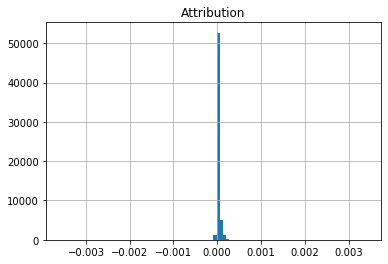

In [37]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

## Downsample to Protein Feature Attributions only

In [38]:
attr.shape
cols = [ens[0] for ens in train_dataset.data.columns.str.split(".")]
feat_imp = pd.DataFrame(data=attr, columns=cols)
feat_imp = feat_imp[feat_imp.columns[np.isin(feat_imp.columns, proteins['ENSEMBL_ID'].values)]]
feat_imp.head()

(45, 60483)

,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003400,ENSG00000003402,ENSG00000003436,ENSG00000003509,ENSG00000003756,ENSG00000003987,ENSG00000003989,ENSG00000004059,ENSG00000004139,ENSG00000004142,ENSG00000004399,ENSG00000004455,ENSG00000004468,ENSG00000004478,ENSG00000004487,ENSG00000004534,ENSG00000004660,ENSG00000004700,ENSG00000004766,ENSG00000004776,ENSG00000004777,ENSG00000004779,ENSG00000004799,ENSG00000004809,ENSG00000004838,ENSG00000004846,ENSG00000004848,ENSG00000004864,ENSG00000004866,ENSG00000004897,ENSG00000004939,ENSG00000004948,ENSG00000004961,ENSG00000004975,ENSG00000005001,ENSG00000005007,ENSG00000005020,ENSG00000005022,ENSG00000005059,ENSG00000005073,ENSG00000005075,ENSG00000005100,ENSG00000005102,ENSG00000005108,ENSG00000005156,ENSG00000005175,ENSG00000005187,ENSG00000005189,ENSG00000005194,ENSG00000005206,ENSG00000005238,ENSG00000005243,ENSG00000005249,ENSG00000005302,ENSG00000005339,ENSG00000005379,ENSG00000005381,ENSG00000005421,ENSG00000005436,ENSG00000005448,ENSG00000005469,ENSG00000005471,ENSG00000005483,ENSG00000005486,ENSG00000005513,ENSG00000005700,ENSG00000005801,ENSG00000005810,ENSG00000005812,ENSG00000005844,ENSG00000005882,ENSG00000005884,ENSG00000005889,ENSG00000005893,ENSG00000005961,ENSG00000005981,ENSG00000006007,ENSG00000006015,ENSG00000006016,ENSG00000006025,ENSG00000006042,ENSG00000006047,ENSG00000006059,ENSG00000006062,ENSG00000006071,ENSG00000006116,ENSG00000006118,ENSG00000006125,ENSG00000006128,ENSG00000006194,ENSG00000006210,ENSG00000006282,ENSG00000006283,ENSG00000006327,ENSG00000006377,ENSG00000006432,ENSG00000006451,ENSG00000006453,ENSG00000006459,ENSG00000006468,ENSG00000006530,ENSG00000006534,ENSG00000006555,ENSG00000006576,ENSG00000006606,ENSG00000006607,ENSG00000006611,ENSG00000006625,ENSG00000006634,ENSG00000006638,ENSG00000006652,ENSG00000006659,ENSG00000006695,ENSG00000006704,ENSG00000006712,ENSG00000006715,ENSG00000006740,ENSG00000006744,ENSG00000006747,ENSG00000006756,ENSG00000006757,ENSG00000006788,ENSG00000006831,ENSG00000006837,ENSG00000007001,ENSG00000007038,ENSG00000007047,ENSG00000007062,ENSG00000007080,ENSG00000007129,ENSG00000007168,ENSG00000007171,ENSG00000007174,ENSG00000007202,ENSG00000007216,ENSG00000007237,ENSG00000007255,ENSG00000007264,ENSG00000007306,ENSG00000007312,ENSG00000007314,ENSG00000007341,ENSG00000007350,ENSG00000007372,ENSG00000007376,ENSG00000007384,ENSG00000007392,ENSG00000007402,ENSG00000007516,ENSG00000007520,ENSG00000007541,ENSG00000007545,ENSG00000007866,ENSG00000007908,ENSG00000007923,ENSG00000007933,ENSG00000007944,ENSG00000007952,ENSG00000007968,ENSG00000008018,ENSG00000008056,ENSG00000008083,ENSG00000008086,ENSG00000008118,ENSG00000008128,ENSG00000008130,ENSG00000008196,ENSG00000008197,ENSG00000008226,ENSG00000008256,ENSG00000008277,ENSG00000008282,ENSG00000008283,ENSG00000008294,ENSG00000008300,ENSG00000008311,ENSG00000008323,ENSG00000008324,ENSG00000008382,ENSG00000008394,ENSG00000008405,ENSG00000008438,ENSG00000008441,ENSG00000008513,ENSG00000008516,ENSG00000008517,ENSG00000008710,ENSG00000008735,ENSG00000008838,ENSG00000008853,ENSG00000008869,ENSG00000008952,ENSG00000008988,ENSG00000009307,ENSG00000009335,ENSG00000009413,ENSG00000009694,ENSG00000009709,ENSG00000009724,ENSG00000009765,ENSG00000009780,ENSG00000009790,ENSG00000009830,ENSG00000009844,ENSG00000009950,ENSG00000009954,ENSG00000010017,ENSG00000010030,ENSG00000010072,ENSG00000010165,ENSG00000010219,ENSG00000010244,ENSG00000010256,ENSG00000010270,ENSG00000010278

In [39]:
pd.merge(feat_imp.loc[10].nlargest(10), proteins, left_index=True, right_on='ENSEMBL_ID')
pd.merge(feat_imp.loc[10].nsmallest(10), proteins, left_index=True, right_on='ENSEMBL_ID')

,10,ENSEMBL_ID,UNIPROT_ID,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Cross-reference (GeneID),Cross-reference (KEGG),Cross-reference (ExpressionAtlas),Tissue specificity,Gene names (primary ),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Ensembl transcript
12867,0.009108,ENSG00000172016,REG3A_HUMAN,Q06141,REG3A_HUMAN,reviewed,Regenerating islet-derived protein 3-alpha (RE...,REG3A HIP PAP PAP1,Homo sapiens (Human),175,Beta strand (9); Chain (2); Disulfide bond (3)...,5068;,hsa:5068;,Q06141;,TISSUE SPECIFICITY: Highly expressed in epider...,REG3A,acute-phase response [GO:0006953]; antimicrobi...,cytoplasm [GO:0005737]; extracellular region [...,cytoplasm [GO:0005737]; extracellular region [...,carbohydrate binding [GO:0030246]; identical p...,GO:0004888; GO:0005576; GO:0005615; GO:0005737...,ENST00000305165;ENST00000393878;ENST00000409839;
8460,0.007027,ENSG00000144852,NR1I2_HUMAN,O75469,NR1I2_HUMAN,reviewed,Nuclear receptor subfamily 1 group I member 2 ...,NR1I2 PXR,Homo sapiens (Human),434,Alternative sequence (4); Beta strand (8); Bin...,8856;,hsa:8856;,O75469;,"TISSUE SPECIFICITY: Expressed in liver, colon ...",NR1I2,cell differentiation [GO:0030154]; cellular re...,intermediate filament cytoskeleton [GO:0045111...,intermediate filament cytoskeleton [GO:0045111...,"DNA-binding transcription activator activity, ...",GO:0000122; GO:0000790; GO:0000976; GO:0000977...,ENST00000337940 [O75469-7];ENST00000638727 [O7...
12315,0.006599,ENSG00000169605,GKN1_HUMAN,Q9NS71,GKN1_HUMAN,reviewed,Gastrokine-1 (18 kDa antrum mucosa protein) (A...,GKN1 AMP18 CA11 UNQ489/PRO1005,Homo sapiens (Human),199,Chain (1); Disulfide bond (1); Domain (1); Err...,56287;,hsa:56287;,NaN,TISSUE SPECIFICITY: Expressed in stomach. No e...,GKN1,digestion [GO:0007586]; positive regulation of...,extracellular space [GO:0005615],extracellular space [GO:0005615]; digestion [G...,NaN,GO:0005615; GO:0007586; GO:0051781,ENST00000377938;
12372,0.003487,ENSG00000169876,MUC17_HUMAN,Q685J3,MUC17_HUMAN,reviewed,Mucin-17 (MUC-17) (Small intestinal mucin-3) (...,MUC17 MUC3,Homo sapiens (Human),4493,Alternative sequence (2); Chain (1); Compositi...,140453;,hsa:140453;,Q685J3;,TISSUE SPECIFICITY: Expressed almost exclusive...,MUC17,cellular homeostasis [GO:0019725]; O-glycan pr...,apical plasma membrane [GO:0016324]; cell [GO:...,apical plasma membrane [GO:0016324]; cell [GO:...,"extracellular matrix constituent, lubricant ac...",GO:0002223; GO:0005623; GO:0005796; GO:0005886...,ENST00000306151 [Q685J3-1];
2301,0.002872,ENSG00000100557,CC198_HUMAN,Q9NVL8,CC198_HUMAN,reviewed,Uncharacterized protein CCDC198,CCDC198 C14orf105,Homo sapiens (Human),296,Chain (1); Natural variant (1); Sequence confl...,55195;,hsa:55195;,Q9NVL8;,NaN,CCDC198,NaN,NaN,NaN,NaN,NaN,ENST00000216445;
6708,0.002786,ENSG00000134193,REG4_HUMAN,Q9BYZ8,REG4_HUMAN,reviewed,Regenerating islet-derived protein 4 (REG-4) (...,REG4 GISP RELP,Homo sapiens (Human),158,Alternative sequence (2); Beta strand (7); Cha...,83998;,hsa:83998;,Q9BYZ8;,TISSUE SPECIFICITY: Highly expressed in the ga...,REG4,response to bacterium [GO:0009617],cytoplasm [GO:0005737]; extracellular region [...,cytoplasm [GO:0005737]; extracellular region [...,heparin binding [GO:0008201]; mannan binding [...,GO:0004888; GO:0005576; GO:0005737; GO:0008201...,ENST00000256585 [Q9BYZ8-1];ENST00000354219 [Q9...
18289,0.002742,ENSG00000241119,UD19_HUMAN,O60656,UD19_HUMAN,reviewed,UDP-glucuronosyltransferase 1-9 (UDPGT 1-9) (U...,UGT1A9 GNT1 UGT1,Homo sapiens (Human),530,Alternative sequence (1); Chain (1); Frameshif...,54600;,hsa:54600;,O60656;,TISSUE SPECIFICITY: Liver. Isoform 1 and isofo...,UGT1A9,cellular glucuronidation [GO:0052695]; flavone...,endoplasmic reticulum [GO:0005783]; endoplasmi...,endoplasmic reticulum [GO:0005783]; endoplasmi...,enzyme binding [GO:0019899]; enzyme inhibitor ...,GO:0001972; GO:0004857; GO:00057

,10,ENSEMBL_ID,UNIPROT_ID,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Cross-reference (GeneID),Cross-reference (KEGG),Cross-reference (ExpressionAtlas),Tissue specificity,Gene names (primary ),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Ensembl transcript
15789,-0.002932,ENSG00000188379,IFNA2_HUMAN,P01563,IFNA2_HUMAN,reviewed,Interferon alpha-2 (IFN-alpha-2) (Interferon a...,IFNA2 IFNA2A IFNA2B IFNA2C,Homo sapiens (Human),188,Beta strand (3); Chain (1); Disulfide bond (2)...,3440;,hsa:3440;,NaN,NaN,IFNA2,adaptive immune response [GO:0002250]; apoptot...,collagen-containing extracellular matrix [GO:0...,collagen-containing extracellular matrix [GO:0...,cytokine activity [GO:0005125]; type I interfe...,GO:0002250; GO:0002286; GO:0002323; GO:0005125...,ENST00000380206;
12950,-0.001529,ENSG00000172367,NHRF4_HUMAN,Q86UT5,NHRF4_HUMAN,reviewed,Na(+)/H(+) exchange regulatory cofactor NHE-RF...,PDZD3 IKEPP NHERF4 PDZK2 DLNB27,Homo sapiens (Human),571,Alternative sequence (6); Beta strand (5); Cha...,79849;,hsa:79849;,Q86UT5;,TISSUE SPECIFICITY: Expressed in kidney and th...,PDZD3,ion transport [GO:0006811]; negative regulatio...,apical part of cell [GO:0045177]; brush border...,apical part of cell [GO:0045177]; brush border...,guanylate cyclase inhibitor activity [GO:00302...,GO:0005829; GO:0005903; GO:0006811; GO:0006833...,ENST00000322712 [Q86UT5-3];ENST00000355547 [Q8...
4569,-0.001383,ENSG00000116833,NR5A2_HUMAN,O00482,NR5A2_HUMAN,reviewed,Nuclear receptor subfamily 5 group A member 2 ...,NR5A2 B1F CPF FTF,Homo sapiens (Human),541,Alternative sequence (3); Beta strand (6); Bin...,2494;,hsa:2494;,O00482;,TISSUE SPECIFICITY: Abundantly expressed in pa...,NR5A2,bile acid metabolic process [GO:0008206]; calc...,cytoplasm [GO:0005737]; nuclear chromatin [GO:...,cytoplasm [GO:0005737]; nuclear chromatin [GO:...,chromatin binding [GO:0003682]; DNA binding [G...,GO:0000790; GO:0000976; GO:0000978; GO:0000981...,ENST00000236914 [O00482-2];ENST00000367362 [O0...
15250,-0.001160,ENSG00000185737,NRG3_HUMAN,P56975,NRG3_HUMAN,reviewed,"Pro-neuregulin-3, membrane-bound isoform (Pro-...",NRG3,Homo sapiens (Human),720,Alternative sequence (4); Chain (2); Compositi...,10718;,hsa:10718;,P56975;,TISSUE SPECIFICITY: Highly expressed in most r...,NRG3,chemorepulsion involved in interneuron migrati...,extracellular region [GO:0005576]; extracellul...,extracellular region [GO:0005576]; extracellul...,chemorepellent activity [GO:0045499]; growth f...,GO:0001558; GO:0005102; GO:0005576; GO:0005615...,ENST00000372141 [P56975-4];ENST00000372142 [P5...
12603,-0.000978,ENSG00000170915,PAQR8_HUMAN,Q8TEZ7,PAQR8_HUMAN,reviewed,Membrane progestin receptor beta (mPR beta) (L...,PAQR8 C6orf33 LMPB1 MPRB,Homo sapiens (Human),354,Chain (1); Erroneous initiation (1); Topologic...,85315;,hsa:85315;,Q8TEZ7;,TISSUE SPECIFICITY: Highly expressed in the hy...,PAQR8,multicellular organism development [GO:0007275...,Golgi apparatus [GO:0005794]; integral compone...,Golgi apparatus [GO:0005794]; integral compone...,signaling receptor activity [GO:0038023]; ster...,GO:0003707; GO:0005496; GO:0005794; GO:0005886...,ENST00000360726;ENST00000442253;
10609,-0.000903,ENSG00000162878,PKDCC_HUMAN,Q504Y2,PKDCC_HUMAN,reviewed,Extracellular tyrosine-protein kinase PKDCC (E...,PKDCC SGK493 VLK,Homo sapiens (Human),493,Active site (1); Binding site (1); Chain (1); ...,91461;,hsa:91461;,Q504Y2;,TISSUE SPECIFICITY: Highly expressed in platel...,PKDCC,bone mineralization [GO:0030282]; cell differe...,extracellular region [GO:0005576]; Golgi appar...,extracellular region [GO:0005576]; Golgi appar...,ATP binding [GO:0005524]; non-membrane spannin...,GO:0001501; GO:0004672; GO:0004715; GO:0005524...,ENST00000294964;
2520,-0.000871,ENSG00000101605,MYOM1_HUMAN,P52179,MYOM1_HUMAN,reviewed,Myomesin-1 (190 kDa connectin-associated prote...,MYOM1,Homo sapiens (Human),1685,Alte

## Inspect Clusters from Feature Attributions

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
plt.rcParams['figure.figsize'] = 12, 12

In [41]:
pca = PCA()
red = pca.fit_transform(feat_imp)

Text(0.5, 1.0, 'Protein Attributions PCA')

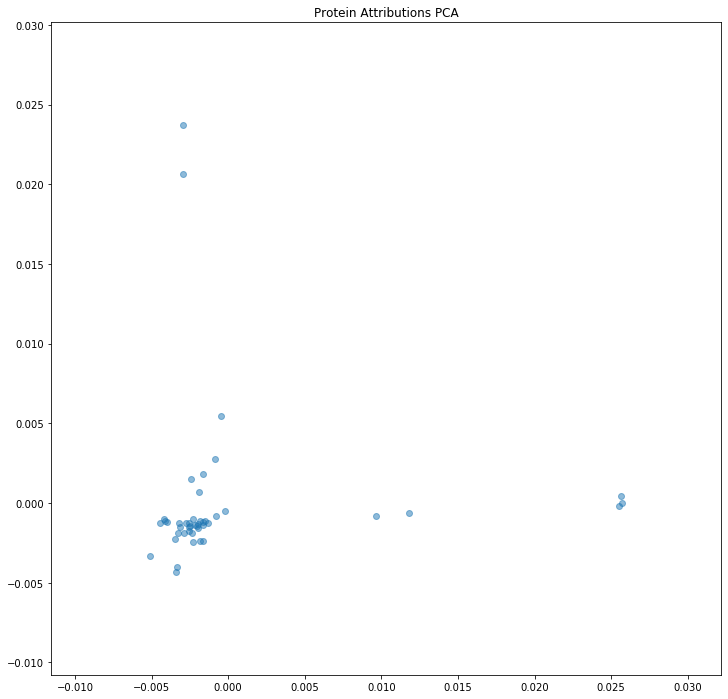

In [42]:
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.title('Protein Attributions PCA')

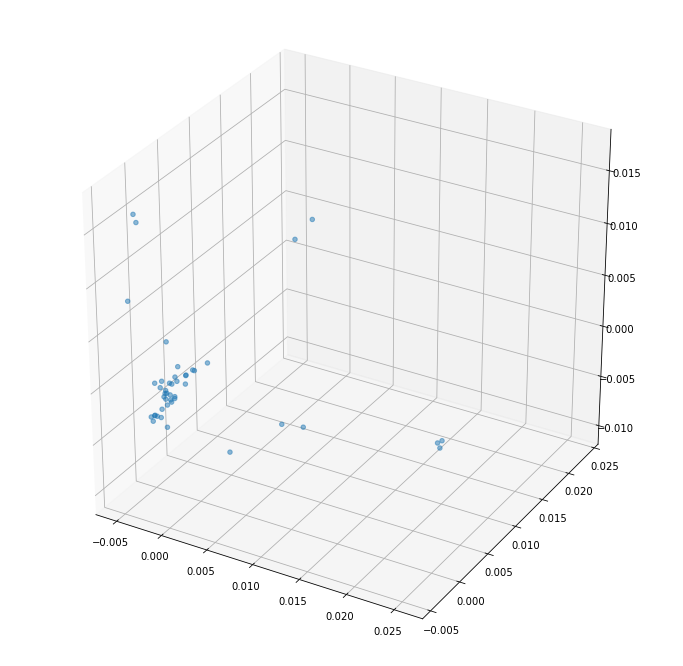

In [43]:
ax = plt.axes(projection='3d')
ax.scatter3D(red[:,0], red[:,1], red[:,2], alpha=0.5)

In [44]:
tsne = TSNE()
red = tsne.fit_transform(feat_imp)

<Figure size 504x504 with 0 Axes>

Text(0.5, 1.0, 'Protein Attributions TNSE')

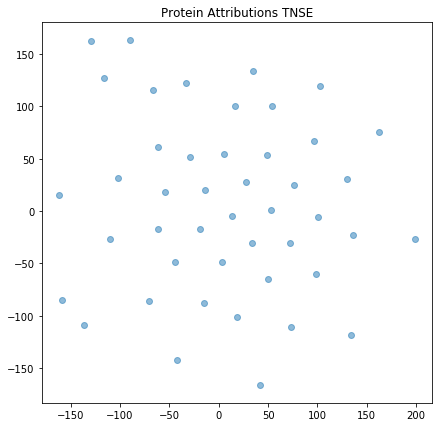

In [45]:
plt.figure(figsize=(7,7))
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.title('Protein Attributions TNSE')

In [46]:
pca = PCA()
red = pca.fit_transform(attr)

<Figure size 504x504 with 0 Axes>

Text(0.5, 1.0, 'All Gene Attributions PCA')

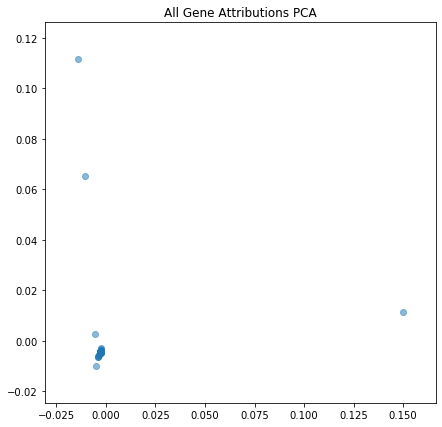

In [47]:
plt.figure(figsize=(7,7))
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.title('All Gene Attributions PCA')

## PCA for raw features

In [138]:
pca = PCA()
red = pca.fit_transform(exp_data.detach().numpy())

(-200, 100)

(-100, 100)

Text(0.5, 1.0, 'Protein Attributions PCA')

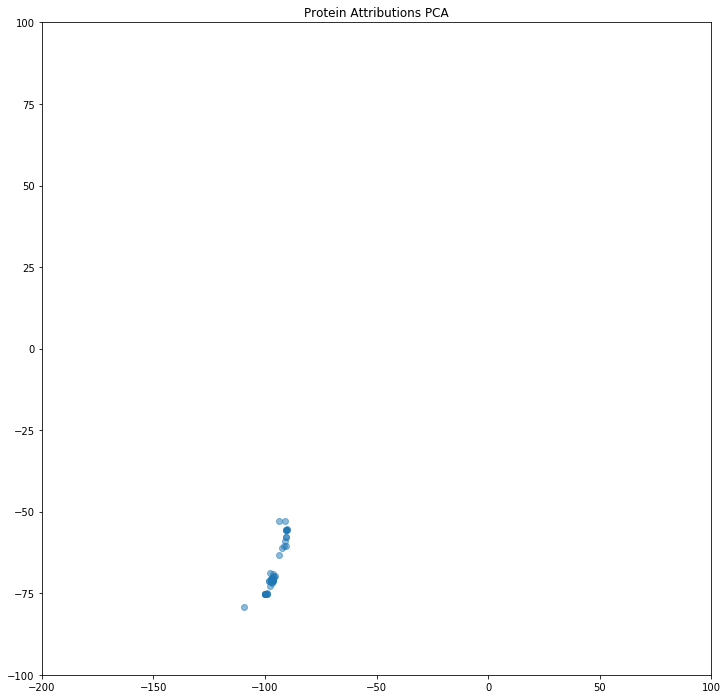

In [140]:
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.xlim((-200,100))
plt.ylim((-100,100))
plt.title('Protein Attributions PCA')

In [123]:
pca = PCA()
red = pca.fit_transform(ctrl_data.detach().numpy())

Text(0.5, 1.0, 'Protein Attributions PCA')

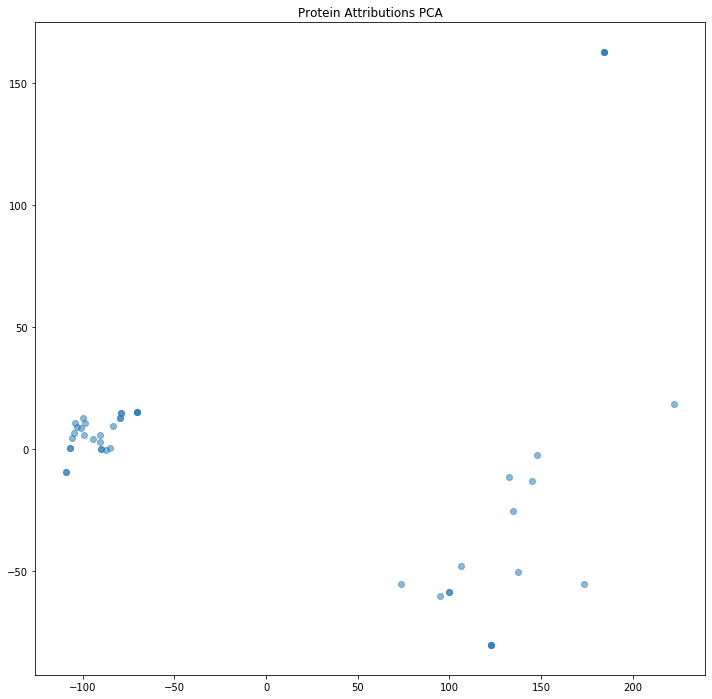

In [124]:
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.title('Protein Attributions PCA')

In [128]:
test_dataset.data.shape
ctrl_data.shape
exp_data.shape

(91, 60483)

torch.Size([45, 60483])

torch.Size([45, 60483])

In [133]:
pca = PCA()
red = pca.fit_transform(test_dataset.data)

(-100, 100)

(-100, 100)

Text(0.5, 1.0, 'Protein Attributions PCA')

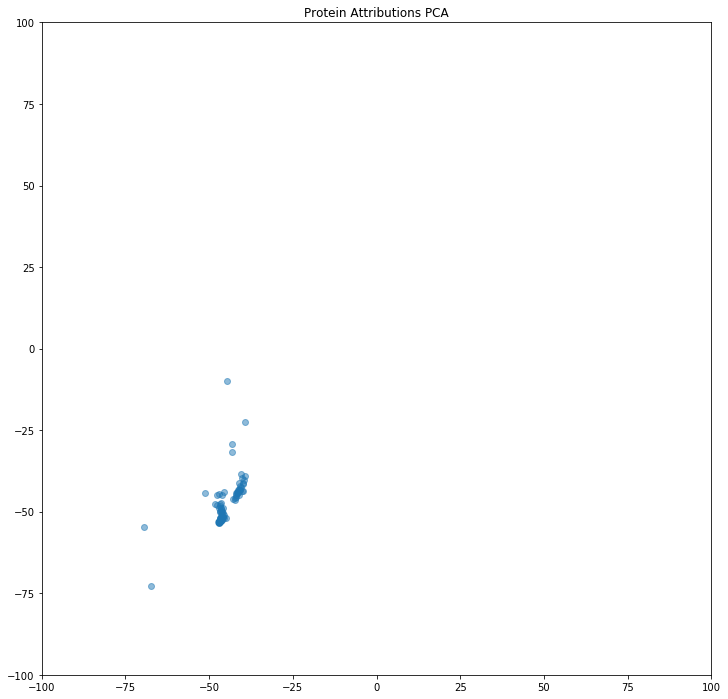

In [134]:
plt.scatter(red[:,0], red[:,1], alpha=0.5)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.title('Protein Attributions PCA')